In [128]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

In [ ]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

# 1) Generate Random SBM Graphon

In [2]:
def generate_proba_matrix(
    max_groups: int,
    range_p_intra: List[float],
    range_p_inter: List[float]
) -> np.ndarray:
    n_groups = np.random.randint(2, max_groups + 1)
    p_intra = np.random.uniform(range_p_intra[0], range_p_intra[1], size=n_groups)
    p = np.random.uniform(range_p_inter[0], range_p_inter[1], size=[n_groups, n_groups])
    np.fill_diagonal(p, p_intra)
    return np.triu(p) + np.triu(p, 1).T

In [3]:
def generate_n_nodes(
    n_groups: int,
    range_n_nodes: List[int]
) -> np.ndarray:
    return np.random.randint(range_n_nodes[0], range_n_nodes[1], n_groups)

In [4]:
def get_graphon_val(
    x: float,
    y: float,
    p: np.ndarray,
    n: np.ndarray
) -> np.ndarray:
    n_nodes = np.sum(n)
    n_nodes_cum = np.cumsum(n)
    
    n_x, n_y = x * n_nodes, y * n_nodes
    i_x, i_y = 0, 0
    while n_x > n_nodes_cum[i_x]:
        i_x += 1
    while n_y > n_nodes_cum[i_y]:
        i_y += 1
    return p[i_x, i_y]

get_graphon = np.vectorize(get_graphon_val, excluded=(2, 3))

In [5]:
def sample_sbm_graphon(
    res: int,
    max_groups: int,
    range_p_intra: List[float],
    range_p_inter: List[float],
    range_n_nodes: List[int]
) -> np.ndarray:
    X, Y = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    p = generate_proba_matrix(max_groups, range_p_intra, range_p_inter)
    n = generate_n_nodes(p.shape[0], range_n_nodes)
    return get_graphon(X, Y, p, n)

In [6]:
w = sample_sbm_graphon(
    res=100,
    max_groups=2,
    range_p_intra=[0.5, 0.8],
    range_p_inter=[0.1, 0.3],
    range_n_nodes=[10, 100]
)

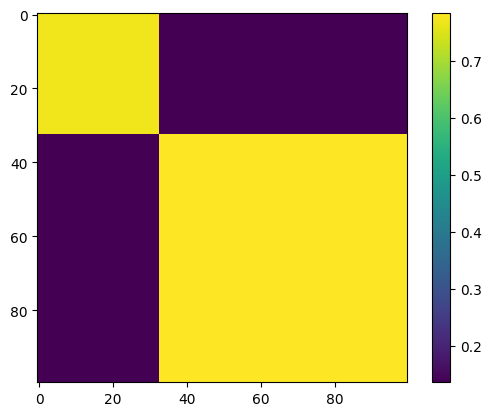

In [7]:
plt.figure()
plt.imshow(w)
plt.colorbar()
plt.show()

# 2) Score Matching with Langevin Dynamics (single noise scale)

References:

* https://jmtomczak.github.io/blog/16/16_score_matching.html

In [431]:
class SamplerLangevin:
    def __init__(
        self,
        dims: int,
        eta: float,
        alpha: float,
        timesteps: int
    ) -> None:
        self.dims = dims
        self.eta = eta
        self.alpha = alpha
        self.timesteps = timesteps

    def sample(
        self,
        batch_size: int,
        model: torch.nn.Module
    ) -> torch.Tensor:
        x = 2.0 * torch.rand_like(torch.empty(batch_size, self.dims)) - 1.0
        for t in range(self.timesteps):
            score = model(x)
            noise = torch.randn_like(x)
            x += self.alpha * score + self.eta * noise  
        return torch.tanh(x)

In [432]:
class ScoreMatching:
    def __init__(
        self,
        sigma: float,
        lr: float,
        dims: int,
        h: int,
    ) -> None:
        self.sigma = sigma
        self.model = nn.Sequential(
            nn.Linear(dims, h), nn.SELU(),
            nn.Linear(h, h), nn.SELU(),
            nn.Linear(h, h), nn.SELU(),
            nn.Linear(h, dims), nn.Hardtanh(min_val=-4., max_val=4.))
        self.optim = torch.optim.Adamax(self.model.parameters(), lr=lr)
        
    def get_loss(self, x: torch.Tensor) -> torch.Tensor:
        eps = torch.randn_like(x)
        x_tilde = x + self.sigma * eps
        s = self.model(x_tilde)
        return (0.5 / self.sigma) * ((s + eps)**2.).sum()

    def update(self, x: torch.Tensor) -> None:
        loss = self.get_loss(x)
        self.optim.zero_grad()
        loss.backward(retain_graph=True)
        self.optim.step()

In [455]:
def evaluation(loader, score_matcher): 
    with torch.no_grad():
        loss, N = 0., 0.
        for _, test_batch in enumerate(loader):
            loss_t = score_matcher.get_loss(test_batch)
            loss = loss + loss_t.item()
            N = N + test_batch.shape[0]
        loss = loss / N
    return loss

def plot_examples(loader, size):
    x = next(iter(loader)).detach().numpy()
    fig, ax = plt.subplots(4, 4)
    for i, ax in enumerate(ax.flatten()):
        img = np.reshape(x[i], size)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

def plot_samples(sampler, model, size):
    with torch.no_grad():
        x = sampler.sample(batch_size=16, model=model)
        x = x.detach().numpy()

    fig, ax = plt.subplots(4, 4)
    for i, ax in enumerate(ax.flatten()):
        img = np.reshape(x[i], size)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

In [347]:
def training(
    epochs: int,
    score_matcher: ScoreMatching,
    training_loader: DataLoader,
    val_loader: DataLoader
) -> np.ndarray:
    nll_val = []
    for e in range(epochs):
        for _, batch in enumerate(training_loader):
            score_matcher.update(batch)
        loss_val = evaluation(val_loader, score_matcher)
        nll_val.append(loss_val)
        print(f'{e}/{epochs}: {loss_val} \r', end='')
    nll_val = np.asarray(nll_val)
    return nll_val

### 2.1) Digits

In [348]:
class Digits(Dataset):
    def __init__(self, mode: str='train') -> None:
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = tt.Lambda(lambda x: 2. * (x / 17.) - 1.)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [349]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [434]:
score_matcher = ScoreMatching(
    sigma=0.1,
    lr=1e-4,
    dims=64,
    h=512
)

sampler_chain = SamplerLangevin(
    dims=64,
    eta=0.05,
    alpha=0.1,
    timesteps=100
)

In [351]:
nll_val = training(
    epochs=200,
    score_matcher=score_matcher,
    training_loader=training_loader,
    val_loader=val_loader
)

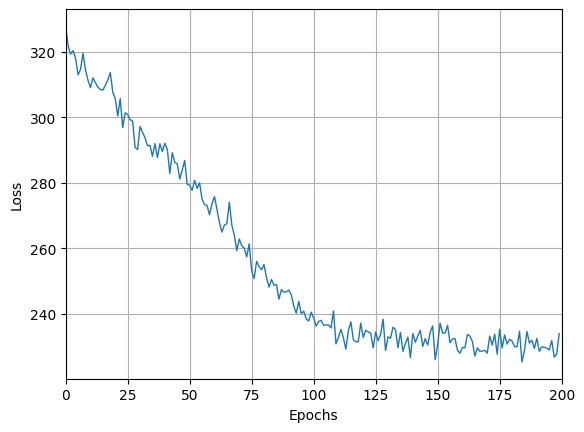

In [352]:
plt.plot(np.arange(len(nll_val)), nll_val, linewidth='1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, num_epochs)
plt.grid()
plt.show()
plt.close()

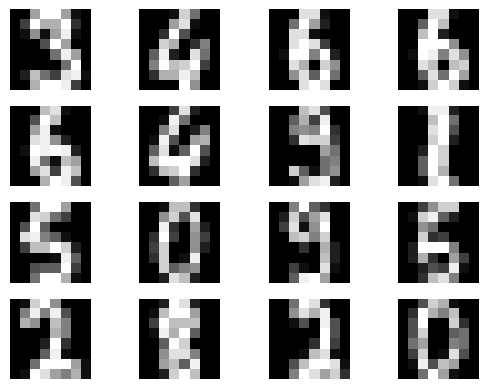

In [314]:
plot_examples(test_loader, (8, 8))

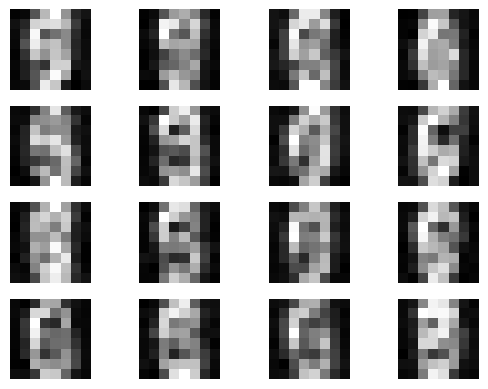

In [315]:
plot_samples(sampler, score_matcher.model, (8, 8))

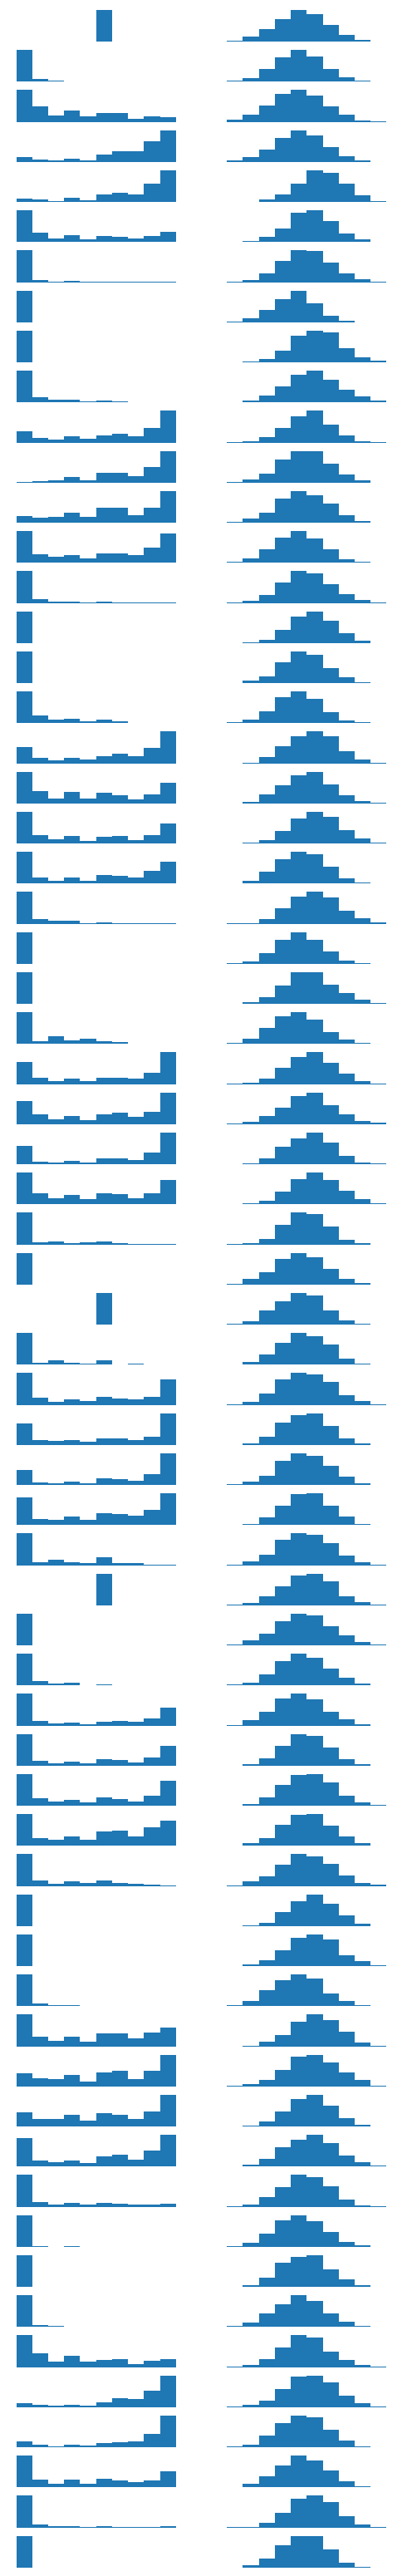

In [500]:
digits = load_digits()
data = (digits.data - digits.data.min()) / (digits.data.max() - digits.data.min())
fig, axes = plt.subplots(nrows=64, ncols=2, figsize=[6, 40])
for i in range(axes.shape[0]):   
    axes[i, 0].axis('off')
    axes[i, 0].hist(data[:, i], bins=10)
    axes[i, 1].axis('off')
    axes[i, 1].hist(data[:, i] + np.random.randn(data.shape[0]), bins=10)
plt.show()

### 2.2 Graphons

In [291]:
class Graphons(Dataset):
    def __init__(self, mode='train'):
        digits = load_digits()
        if mode == 'train':
            self.data = self._generate_data(1_000)
        elif mode == 'val':
            self.data = self._generate_data(200)
        else:
            self.data = self._generate_data(200)
    
    def _generate_data(self, size):
        data = []
        for _ in range(size):
            w = sample_sbm_graphon(
                res=10,
                max_groups=2,
                range_p_intra=[0.5, 0.8],
                range_p_inter=[0.1, 0.3],
                range_n_nodes=[10, 100]
            )
            data.append(w.flatten())
        return np.array(data).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [295]:
train_data = Graphons(mode='train')
val_data = Graphons(mode='val')
test_data = Graphons(mode='test')

training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [296]:
score_matcher = ScoreMatching(
    sigma=0.1,
    lr=1e-4,
    dims=100,
    h=512
)

sampler = SamplerLangevin(
    dims=100,
    eta=0.05,
    alpha=0.1,
    timesteps=100
)

In [297]:
nll_val = training(
    epochs=300,
    score_matcher=score_matcher,
    training_loader=training_loader,
    val_loader=val_loader
)

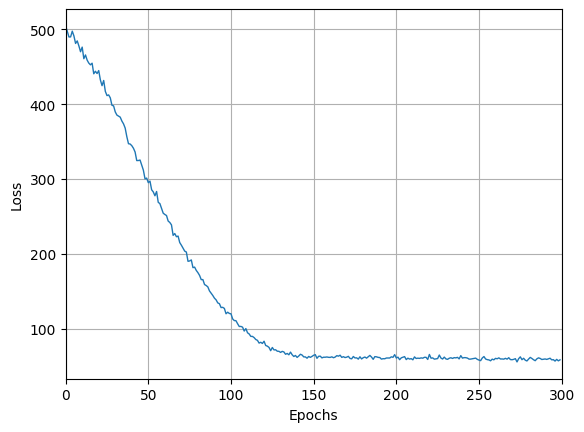

In [298]:
plt.plot(np.arange(len(nll_val)), nll_val, linewidth='1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 300)
plt.grid()
plt.show()
plt.close()

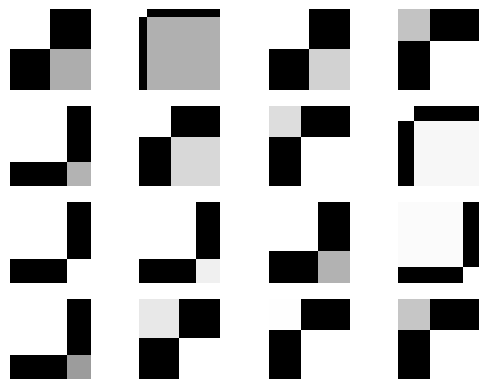

In [299]:
plot_examples(test_loader, size=(10, 10))

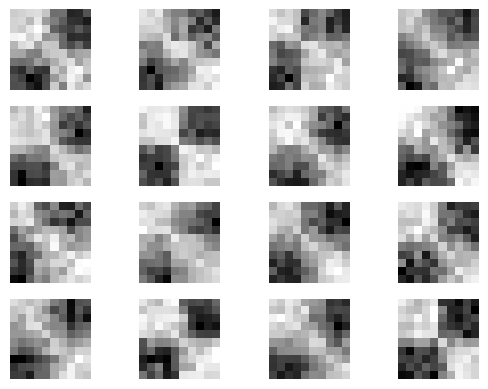

In [300]:
plot_samples(sampler, score_matcher.model, size=(10, 10))

# 3) Score Matching with Langevin Dynamics (multiple noise scales)

References:

* https://ericmjl.github.io/score-models/
* https://yang-song.net/blog/2021/score/

In [638]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
    def __init__(
        self,
        noise_scales,
        channels=[32, 64],
        embed_dim=256
    ):
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        # Decoding layers where the resolution increases
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=2)    

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.noise_scales = noise_scales
  
    def forward(self, x, t):
        t_vec = torch.tensor([t] * x.shape[0])
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t_vec))
        # Encoding path
        h1 = self.conv1(x)
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        print(h1.shape)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        print(h1.shape)
        """
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)
        """
        
        """
        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        """
        h = self.tconv2(h2)
        ## Skip connection from the encoding path
        h += self.dense3(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.noise_scales[t]
        return h

In [761]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
    def __init__(
        self,
        noise_scales,
        dims,
        h
    ):
        super().__init__()

        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=h),
            nn.Linear(h, h),
        )
        
        self.linear1 = nn.Linear(dims, h)
        self.linear2 = nn.Linear(h, h)
        self.linear3 = nn.Linear(h, h) 
        self.linear4 = nn.Linear(h, h) 
        self.linear5 = nn.Linear(h, dims) 

        self.act = lambda x: x * torch.sigmoid(x)
        self.noise_scales = noise_scales
  
    def forward(self, x, t):
        t_vec = torch.tensor([t] * x.shape[0])
        embed = self.act(self.embed(t_vec))

        h1 = self.linear1(x) 
        h1 += self.linear2(embed)
        h1 = nn.SELU()(h1)
    
        h2 = self.linear3(h1)
        h2 = nn.SELU()(h2)
        
        h3 = self.linear4(h2)
        h3 = nn.SELU()(h3)
        
        h4 = self.linear5(h3)
        h4 = nn.Hardtanh(min_val=-4., max_val=4.)(h4)
        h4 = h4 / self.noise_scales[t]
        return h4

In [801]:
class ScoreNet(nn.Module):
    def __init__(
        self,
        noise_scales,
        dims,
        h
    ):
        super().__init__()
        
        self.models = nn.ModuleList([nn.Sequential(
            nn.Linear(dims, h), nn.SELU(),
            nn.Linear(h, h), nn.SELU(),
            nn.Linear(h, h), nn.SELU(),
            nn.Linear(h, dims), nn.Hardtanh(min_val=-4., max_val=4.))
                       for _ in range(len(noise_scales))])

        self.noise_scales = noise_scales
  
    def forward(self, x, t):
        return self.models[t](x) # / self.noise_scales[t]

In [933]:
class SamplerLangevinChain:
    def __init__(
        self,
        dims: int,
        eta: float,
        h: int,
        t_last: int,
        sigmas: int,
    ) -> None:
        self.dims = dims
        self.eta = eta
        self.h = h
        self.t_last = t_last
        self.sigmas = sigmas

    def sample(
        self,
        batch_size: int,
        model: torch.nn.Module
    ) -> torch.Tensor:
        x = 2.0 * torch.rand_like(torch.empty(batch_size, self.dims)) - 1.0
        for t in reversed(range(self.t_last)):
            alpha = self.eta * (self.sigmas[t] / self.sigmas[-1])**2
            for _ in range(self.h):
                score = model(x, t) / self.sigmas[t]
                noise = torch.randn_like(x)
                x += alpha * score + np.sqrt(2 * alpha) * noise  
        return torch.tanh(x)
    
    def sample_trajectory(
        self,
        batch_size: int,
        model: torch.nn.Module
    ) -> torch.Tensor:
        x = 2.0 * torch.rand_like(torch.empty(batch_size, self.dims)) - 1.0
        samples = [x.detach().clone().numpy()]
        for t in reversed(range(self.t_last)):
            alpha = self.eta * (self.sigmas[t] / self.sigmas[-1])**2
            for _ in range(self.h):
                score = model(x, t) / self.sigmas[t]
                noise = torch.randn_like(x)
                x += alpha * score + np.sqrt(2 * alpha) * noise  
            samples.append(torch.tanh(x).detach().numpy())
        return samples

In [804]:
class ScoreMatching:
    def __init__(
        self,
        min_sigma: float,
        max_sigma: float,
        t_last: int,
        lr: float,
        dims: int,
        h: int,
    ) -> None:
        self.t_last = t_last
        self.sigmas = self._init_sigmas(min_sigma, max_sigma, t_last)
        self.model = ScoreNet(self.sigmas, dims, h)
        self.optim = torch.optim.Adamax(self.model.parameters(), lr=lr)
        
    def _init_sigmas(self, min_sigma: float, max_sigma: float, t_last: int) -> List[float]:
        r = (max_sigma / min_sigma) ** (1 / t_last)    
        sigmas = [min_sigma * (r ** i) for i in range(t_last + 1)]

        if sigmas[-1] > max_sigma:
            sigmas.pop()

        return sigmas
        
    def get_loss(self, x: torch.Tensor, t: int) -> torch.Tensor:
        eps = torch.randn_like(x)
        x_tilde = x + self.sigmas[t] * eps
        score = self.model(x_tilde, t)
        target = - eps # / self.sigmas[t]
        lambda_ = 1 # self.sigmas[t] ** 2
        loss = lambda_ * (score - target) ** 2
        return loss.sum()

    def update(self, x: torch.Tensor) -> None:
        t = np.random.randint(self.t_last)
        loss = self.get_loss(x, t)
        self.optim.zero_grad()
        loss.backward(retain_graph=True)
        self.optim.step()

In [925]:
def evaluation(loader, score_matcher, t_last): 
    with torch.no_grad():
        loss, N = 0., 0.
        for t in range(t_last):
            for _, test_batch in enumerate(loader):
                loss_t = score_matcher.get_loss(test_batch, t)
                loss = loss + loss_t.item()
                N = N + test_batch.shape[0]
        loss = loss / N
    return loss

def plot_examples(loader, size):
    x = next(iter(loader)).detach().numpy()
    fig, ax = plt.subplots(4, 4)
    for i, ax in enumerate(ax.flatten()):
        img = np.reshape(x[i], size)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

def plot_samples_chain(sampler, model, size):
    with torch.no_grad():
        x = sampler.sample(batch_size=16, model=model)
        x = x.detach().numpy()

    fig, ax = plt.subplots(4, 4)
    for i, ax in enumerate(ax.flatten()):
        img = np.reshape(x[i], size)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()
    
def plot_chain(sampler, model, size):
    with torch.no_grad():
        samples = sampler.sample_trajectory(batch_size=4, model=model)

    fig, ax = plt.subplots(101, 4, figsize=[6, 100])
    for i in range(101):
        for j in range(4):
            img = np.reshape(samples[i][j], size)
            ax[i, j].imshow(img, cmap='gray')
            ax[i, j].axis('off')
    plt.show()

In [806]:
def training(
    epochs: int,
    t_last: int,
    score_matcher: ScoreMatching,
    training_loader: DataLoader,
    val_loader: DataLoader
) -> np.ndarray:
    nll_val = []
    for e in range(epochs):
        for _, batch in enumerate(training_loader):
            score_matcher.update(batch)
        loss_val = evaluation(val_loader, score_matcher, t_last)
        nll_val.append(loss_val)
        print(f'{e}/{epochs}: {loss_val} \r', end='')
    nll_val = np.asarray(nll_val)
    return nll_val

### 3.1) Digits

In [807]:
class Digits(Dataset):
    def __init__(self, mode: str='train') -> None:
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = tt.Lambda(lambda x: 2. * (x / 17.) - 1.)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = self.transforms(sample)
        return sample

In [808]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [959]:
score_matcher = ScoreMatching(
    min_sigma=0.01,
    max_sigma=1.0,
    t_last=100,
    lr=1e-4,
    dims=64,
    h=512
)

In [960]:
sampler_chain = SamplerLangevinChain(
    dims=64,
    eta=1e-3,
    sigmas=score_matcher.sigmas,
    h=500,
    t_last=100,
)

In [978]:
nll_val = training(
    epochs=10_000,
    score_matcher=score_matcher,
    training_loader=training_loader,
    val_loader=val_loader,
    t_last=100,
)

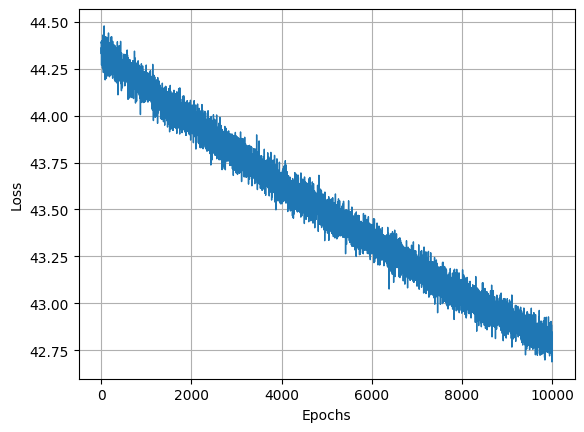

In [986]:
plt.plot(np.arange(len(nll_val)), nll_val, linewidth='1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xlim(0, 20_000)
plt.grid()
plt.show()
plt.close()

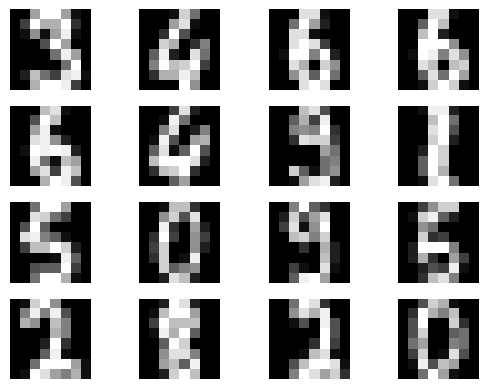

In [980]:
plot_examples(test_loader, (8, 8))

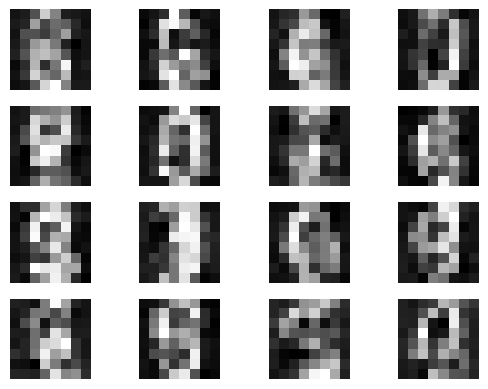

In [981]:
plot_samples_chain(sampler_chain, score_matcher.model, (8, 8))

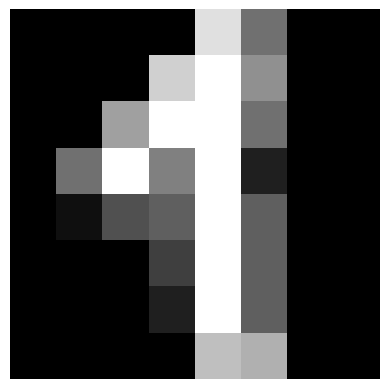

In [982]:
x = batch[0]
plt.imshow(x.reshape(8, 8), cmap='gray')
plt.axis('off')
plt.show()

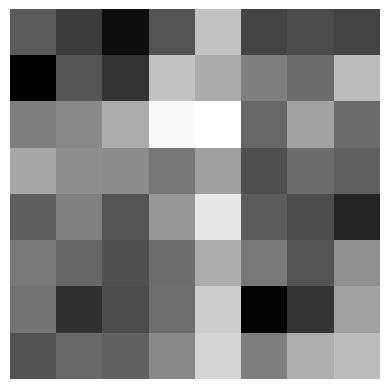

In [983]:
t = 99
x_tilde = x + score_matcher.sigmas[t] * torch.randn_like(x)
plt.imshow(x_tilde.reshape(8, 8), cmap='gray')
plt.axis('off')
plt.show()

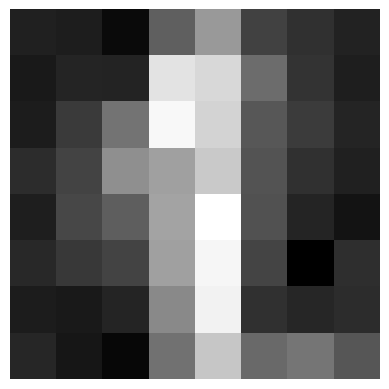

In [984]:
x_denoised = x_tilde + score_matcher.sigmas[t] * score_matcher.model(x_tilde, t)
plt.imshow(x_denoised.detach().numpy().reshape(8, 8), cmap='gray')
plt.axis('off')
plt.show()

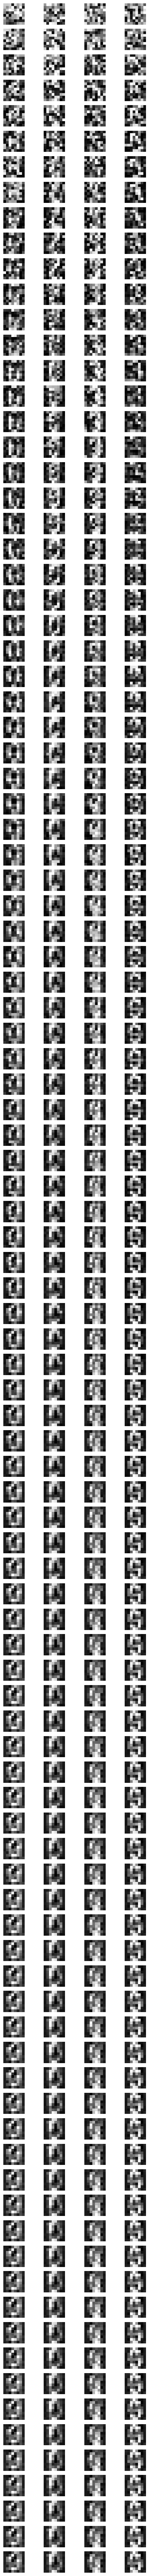

In [985]:
plot_chain(sampler_chain, score_matcher.model, (8, 8))

### 3.2) Graphons dataset

In [987]:
class Graphons(Dataset):
    def __init__(self, mode='train'):
        digits = load_digits()
        if mode == 'train':
            self.data = self._generate_data(1_000)
        elif mode == 'val':
            self.data = self._generate_data(200)
        else:
            self.data = self._generate_data(200)
    
    def _generate_data(self, size):
        data = []
        for _ in range(size):
            w = sample_sbm_graphon(
                res=10,
                max_groups=2,
                range_p_intra=[0.5, 0.8],
                range_p_inter=[0.1, 0.3],
                range_n_nodes=[10, 100]
            )
            data.append(w.flatten())
        return np.array(data).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return 2 * self.data[idx] - 1

In [988]:
train_data = Graphons(mode='train')
val_data = Graphons(mode='val')
test_data = Graphons(mode='test')

training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [992]:
score_matcher = ScoreMatching(
    min_sigma=0.01,
    max_sigma=1.0,
    t_last=100,
    lr=1e-3,
    dims=100,
    h=512
)

In [1155]:
sampler_chain = SamplerLangevinChain(
    dims=100,
    eta=1e-3,
    sigmas=score_matcher.sigmas,
    h=100,
    t_last=100,
)

In [1157]:
# 350_000
nll_val = training(
    epochs=50_000,
    score_matcher=score_matcher,
    training_loader=training_loader,
    val_loader=val_loader,
    t_last=100,
)

KeyboardInterrupt: 

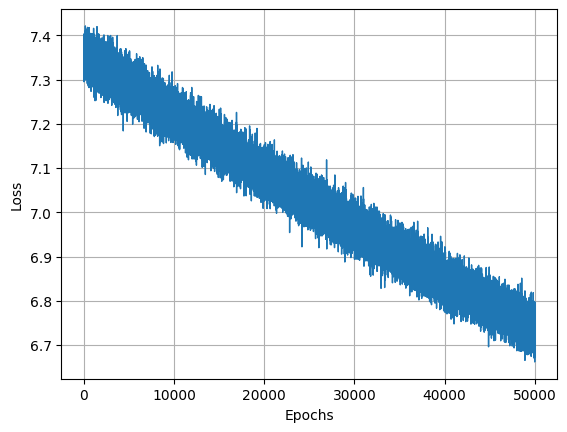

In [1158]:
plt.plot(np.arange(len(nll_val)), nll_val, linewidth='1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xlim(0, 20_000)
plt.grid()
plt.show()
plt.close()

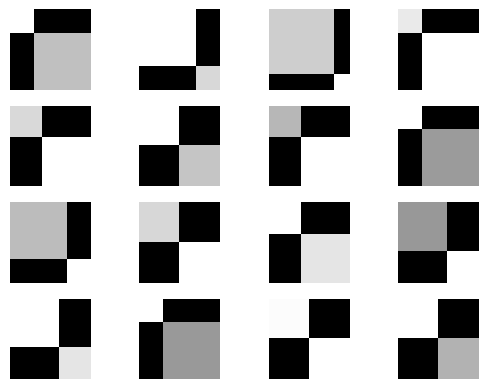

In [1159]:
plot_examples(test_loader, (10, 10))

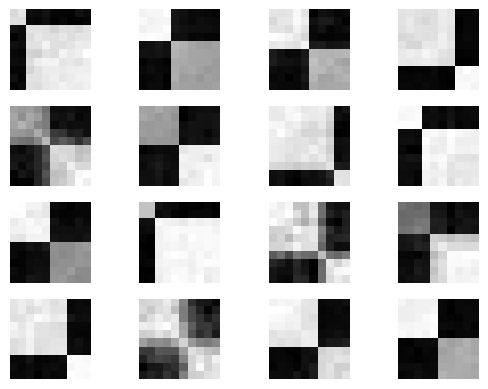

In [1167]:
plot_samples_chain(sampler_chain, score_matcher.model, (10, 10))

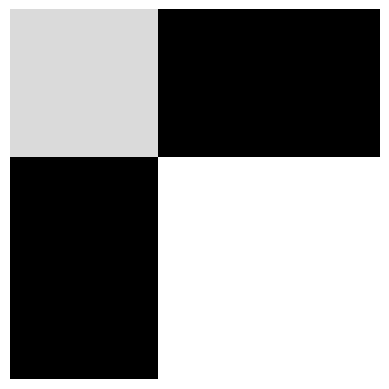

In [1161]:
x = torch.tensor(train_data[0])
plt.imshow(x.reshape(10, 10), cmap='gray')
plt.axis('off')
plt.show()

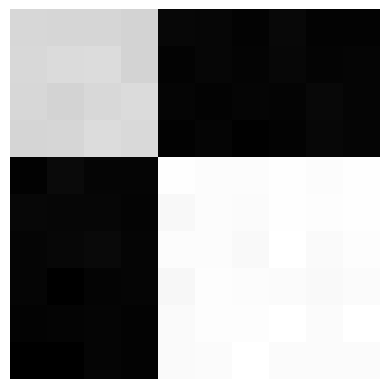

In [1162]:
t = 0
x_tilde = x + score_matcher.sigmas[t] * torch.randn_like(x)
plt.imshow(x_tilde.reshape(10, 10), cmap='gray')
plt.axis('off')
plt.show()

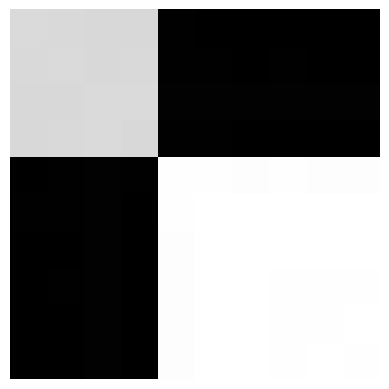

In [1163]:
x_denoised = x_tilde + score_matcher.sigmas[t] * score_matcher.model(x_tilde, t)
plt.imshow(x_denoised.detach().numpy().reshape(10, 10), cmap='gray')
plt.axis('off')
plt.show()

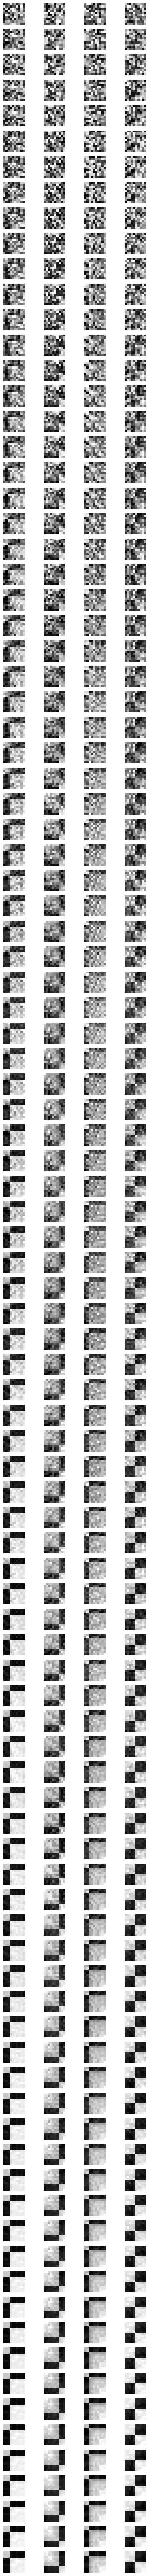

In [1164]:
plot_chain(sampler_chain, score_matcher.model, (10, 10))